## Init and Run GMM

In [1]:
%%javascript
Jupyter.utils.load_extensions('tdb_ext/main')

<IPython.core.display.Javascript object>

In [2]:
#this sets the backend to jupyter/ipython that (i think) displays
#     images directly. anyway, it prevents the matplotlib framework
#     python error that is my least favorite thing eeeevvvveeeer.
%matplotlib notebook

import sys
import os
os.chdir('/Users/azane/GitRepo/spider') #TODO just make actual modules?
sys.path.append("./scripts27")
sys.path.append("./scripts27/gauss_mix")

import gmix_model as gmix
import numpy as np
import tdb as tdb
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gmix_sample_mixture as smpl
import graph_NPZ as graph_highD
import spider_solution_explorers as sexp

In [3]:
def remove_nan_rows(x, y):
    #hstack negated isnan checks
    b = ~(np.hstack((np.isnan(x), np.isnan(y))))
    #get rows where all columns are True (not nan)
    b = b.all(axis=1)
    
    return x[b], y[b]

In [4]:
#read in training and test data
s_x, s_t = gmix.get_xt_from_npz('data/spi_data.npz', True)
#t_x, t_t = gmix.get_xt_from_npz('data/spi_gmix_test.npz', True)
t_x, t_t = gmix.get_xt_from_npz('data/spi_data.npz', True)

#train for only some dimensions.
#xDims = np.array([0,1,2,-1]) #muscle, muscle, balance, time
#s_x = s_x[:,xDims]
#t_x = t_x[:,xDims]

s_x, s_t = remove_nan_rows(s_x, s_t)
t_x, t_t = remove_nan_rows(t_x, t_t)

#TEMP
#expand target dimension so variance can be happy.
#scaleOut = 100
#s_t *= scaleOut
#t_t *= scaleOut

### Note on Scaling and Variance Saturation:

   ```GaussianMixtureModel``` needs to handle the variance scaling. The question is, should it scale up from tanh and *then* calculate loss? Or should it keep everything within the tanh range, and then scale up only for outputs?
   
   If the actual range is large, then it would be more accurate and safer to scale up to the range. But, like in the spider example, if the range is small, so it would actually be safer to keep it at tanh. I think if it can be determined that the tanh range can accurately represent the means and variances, then it's best to keep it there. Otherwise, we might need to expand everything to a middle-man range where loss can be calculated, and then expand to the actual range on formula retrieval.

### GMM Init

In [5]:
#create gmm with data
np.random.seed(np.random.randint(100000))
gmm = gmix.GaussianMixtureModel(np.copy(s_x), np.copy(s_t),
                                np.copy(t_x), np.copy(t_t),
                               numGaussianComponents=15, hiddenLayerSize=20,
                               learningRate=1e-2) #0.005 worked for 2d

### ExplorerHQ Init

In [6]:
explorerHQ = sexp.ExplorerHQ(numExplorers=3,
                             
                             xRange=gmm.inRange, sRange=gmm.outRange,
                             #note that because the explorers are using the
                             #  refDict of the net being trained,
                             #  the weights will be automatically updated.
                             #  and there is no need to call the updater.
                             forwardRD=gmm.get_refDict(),
                             
                             certainty_func=sexp.gmm_bigI,
                             expectation_func=sexp.gmm_expectation,
                             parameter_update_func=sexp.gmm_p_updater,
                             
                             sensorGoal=np.array([-1.7]),
                             modifiers=dict(C=.2, T=.1, S=2.))

### Thoughts on Hyperparameters

  * The larger the hidden layers, the more representations of globally best solutions. Thus, a slower training rate can be afforded, as there are more routes out of local minima.
  * Small hidden layers may require a larger training rate so it can jump out of local minima.
  * Examining the mixing coefficient averages reveals whether or not some gaussian components are not being used. These should be minimized.
 
### Hyperparameters as Variables

   * We need an **intelligent learning rate**. It should make guesses as to whether it's stuck in a local minima, or honing in on a good solution. If it thinks it's stuck, set the learning rate high to jump out, if it's working on a good solution, keep the learning rate low to stay on track.
      * the loss function needs to scale with the number of samples, otherwise we'll see steeper gradients for for larger sample batches.
   * The **number of gaussian components** can be selected based on how many are being used, and how much. Having this change during training would require a restructuring of the network, however, and preserving training before restructuring may be impossible.
      * in other words, this may slow down training considerably, but complexity reduction would vastly increase execution.
   * It may be worth spawning **a number of networks** working on the same solution. This is a good way to determine whether a **local or global** solution has been found.
#### ```numGaussianComponents``` Hyperparameter
If the network is initialized with a large number of gaussian components, there are more chances for a mean to start close to the correct values. The most relevant components (or parts of those components; sampling can occur given mixing coefficients) can then be selected, and a data set can be built to train the only network layer for the means; that is, to train the output activations of the means. After the output activations of the means are trained, normal training can resume considering the full GMM.

# Train Step

In [24]:
%%capture
#d will be a dictionary of evaluated tensors under their standard name.
sessions = 10

sessionIterations = 100
runTimes = sessions*sessionIterations

gmm.train(iterations=runTimes, testBatchSize=1000,
          trainBatchSize=3000, reportEvery=sessionIterations)



In [25]:
#get trained data
evalStr = [
    'calc_agg_grad_w1',
    'calc_agg_grad_b1',
    'calc_agg_grad_w2',
    'calc_agg_grad_b2',
    'calc_agg_grad_w3',
    'calc_agg_grad_b3',

    'v',
    'm',
    
    'w1',
    'w2',
    'w3',
    'b1',
    'b2',
    'b3'
    ]
d = gmm.get_evals(evalStr)

In [37]:
print d['w1']
print d['b2']


[[-0.63670707  0.51202643 -0.10317091 -0.3283456   0.29409036  0.02588983
  -0.08421972 -0.32407063 -0.22173798  0.26387197 -0.06167981  0.52580291
   0.33310366 -0.67169851 -0.23595318  0.16308959  0.26722851 -0.19816263
   0.1575291  -0.21343729]
 [-0.67254418 -0.65284866  0.09875209  0.58191162 -0.57357168 -0.3070676
   0.15890649 -0.25300345 -0.36547688  0.98146415  0.28058013  0.0811476
   0.69216126 -0.09804464  0.21184456 -0.34562165  0.44617945 -0.05200143
  -0.4641178  -0.84905821]
 [-0.52842879  0.3510538  -0.20785439 -0.26842037  0.28493315  0.06196781
   0.03523535 -0.10909382  0.35480455  0.17676549  0.58412123 -0.53000981
  -0.02334209  0.73200458 -0.45827889 -0.1083566  -0.53472519  0.02185927
  -0.11339992 -0.78077388]
 [ 0.09080441  0.7334829  -0.04473595  0.78187096 -0.58248115 -0.14827231
  -0.22776142  0.44036177  0.38531974  0.19566219  0.10179637  0.22420616
  -0.03900081  0.08787901 -0.13357024 -0.09478767  0.64514387  1.37079382
   0.04143248  0.86473221]]
[ 0.5

# Visualization

In [35]:
#get mvu from test vals
m, v, u = gmm.get_xmvu()

#send weights to explorerHQ
explorerHQ.update_params(
                            w1=d['w1'],
                            w2=d['w2'],
                            w3=d['w3'],
                            b1=d['b1'],
                            b2=d['b2'],
                            b3=d['b3']
                        )

#get point value calculations
_, pv_v, pv_c, pv_t, pv_s, pv_tests = explorerHQ.graph_space(s_x)
#expand to 2d for graphing reqs.
pv_v = np.expand_dims(pv_v, 1)

#get gmm estimations
_, y_smpl = smpl.sample_mixture(s_x, m, v, u) #set to gmm sample
_, y = smpl.mixture_expectation(s_x, m, v, u) #set to gmm expectation

xCols = [1,2,-1]
yLow = None#-0.03*scaleOut
yHigh = None#0.03*scaleOut

modifiers: 
{'C': 0.12571524300793382, 'S': 0.76053290110100413, 'T': 0.11375185589106206}


In [10]:
print pv_v.shape

(5000, 1)


<IPython.core.display.Javascript object>


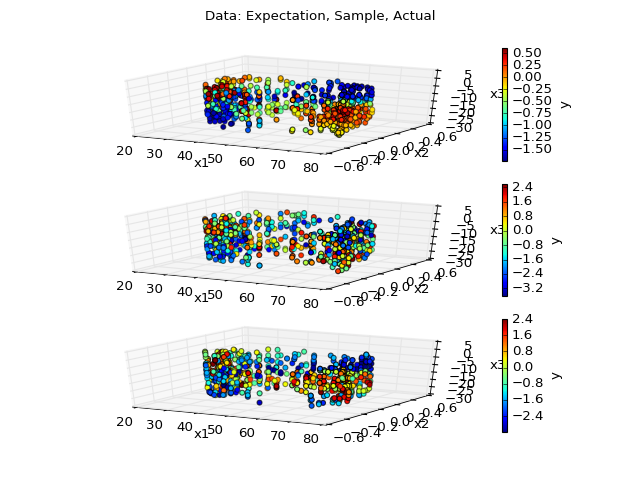

In [27]:
#actual data
fig, _ = graph_highD.graph3x1y(s_x, y, xCols=xCols,
                      yLow=yLow, yHigh=yHigh,
                      sbpltLoc=311, numPoints=700)
graph_highD.graph3x1y(s_x, y_smpl, xCols=xCols,
                      yLow=yLow, yHigh=yHigh, fig=fig,
                      sbpltLoc=312, numPoints=700)
graph_highD.graph3x1y(s_x, s_t, xCols=xCols,
                      yLow=yLow, yHigh=yHigh, fig=fig,
                      sbpltLoc=313, numPoints=700)
fig.suptitle('Data: Expectation, Sample, Actual')

<IPython.core.display.Javascript object>


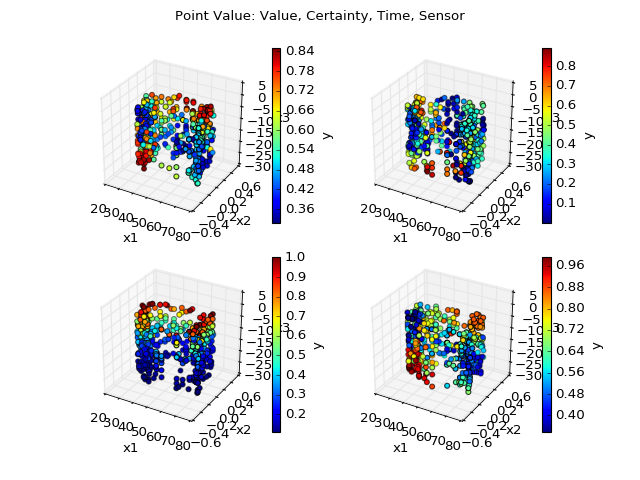

In [12]:
#point value
fig, _ = graph_highD.graph3x1y(s_x, pv_v, xCols=xCols,
                      sbpltLoc=221, numPoints=500)
graph_highD.graph3x1y(s_x, pv_c, xCols=xCols, fig=fig,
                      sbpltLoc=222, numPoints=500)
graph_highD.graph3x1y(s_x, pv_t, xCols=xCols, fig=fig,
                      sbpltLoc=223, numPoints=500)
graph_highD.graph3x1y(s_x, pv_s, xCols=xCols, fig=fig,
                      sbpltLoc=224, numPoints=500)
fig.suptitle('Point Value: Value, Certainty, Time, Sensor')

<IPython.core.display.Javascript object>


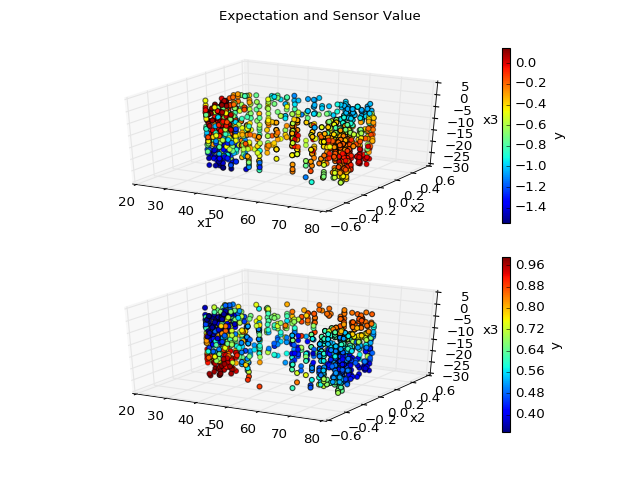

In [13]:
#expectation and sensor value
fig, _ = graph_highD.graph3x1y(s_x, y, xCols=xCols,
                      sbpltLoc=211, numPoints=1000)
graph_highD.graph3x1y(s_x, pv_s, xCols=xCols, fig=fig,
                      sbpltLoc=212, numPoints=1000)
fig.suptitle('Expectation and Sensor Value')



<IPython.core.display.Javascript object>


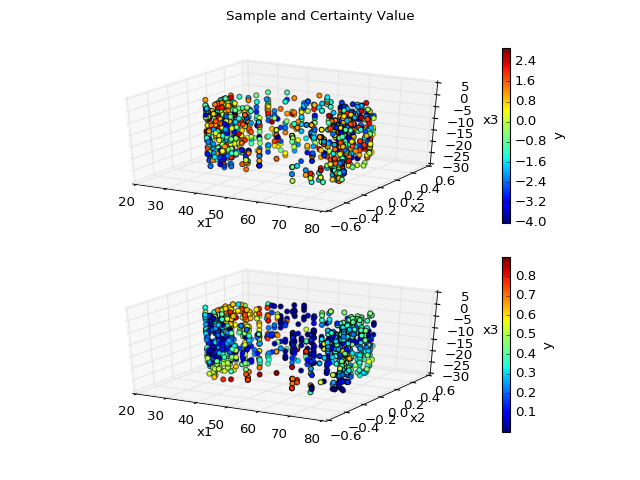

In [14]:
#sample and certainty value
fig, _ = graph_highD.graph3x1y(s_x, y_smpl, xCols=xCols,
                      sbpltLoc=211, numPoints=1000)
graph_highD.graph3x1y(s_x, pv_c, xCols=xCols, fig=fig,
                      yHigh=None, yLow=None,
                      sbpltLoc=212, numPoints=1000)
fig.suptitle('Sample and Certainty Value')

## Debugging

In [39]:
print pv_tests[3]

[[-0.63670707  0.51202643 -0.10317091 -0.3283456   0.29409036  0.02588983
  -0.08421972 -0.32407063 -0.22173798  0.26387197 -0.06167981  0.52580291
   0.33310366 -0.67169851 -0.23595318  0.16308959  0.26722851 -0.19816263
   0.1575291  -0.21343729]
 [-0.67254418 -0.65284866  0.09875209  0.58191162 -0.57357168 -0.3070676
   0.15890649 -0.25300345 -0.36547688  0.98146415  0.28058013  0.0811476
   0.69216126 -0.09804464  0.21184456 -0.34562165  0.44617945 -0.05200143
  -0.4641178  -0.84905821]
 [-0.52842879  0.3510538  -0.20785439 -0.26842037  0.28493315  0.06196781
   0.03523535 -0.10909382  0.35480455  0.17676549  0.58412123 -0.53000981
  -0.02334209  0.73200458 -0.45827889 -0.1083566  -0.53472519  0.02185927
  -0.11339992 -0.78077388]
 [ 0.09080441  0.7334829  -0.04473595  0.78187096 -0.58248115 -0.14827231
  -0.22776142  0.44036177  0.38531974  0.19566219  0.10179637  0.22420616
  -0.03900081  0.08787901 -0.13357024 -0.09478767  0.64514387  1.37079382
   0.04143248  0.86473221]]


In [16]:
print pv_tests[7].shape
print pv_tests[8].shape
print pv_tests[9].shape
print pv_tests[9].mean()
print pv_tests[9].max()
print pv_tests[9].min()

(5000, 1)
(5000, 1)
(5000, 1)
0.471366
0.757263
0.25437


In [17]:
print "errDen"
print pv_tests[0].shape
print pv_tests[0]
print
print "errNum"
print pv_tests[1].shape
print pv_tests[1]
print
print "sensorVal"
print pv_tests[2].shape
print pv_tests[2]

err = pv_tests[1]/pv_tests[0]

print
print "error"
print err
print np.mean(err)

print

errDen
(1, 1)
[[ 31.30235863]]

errNum
(5000, 1)
[[ 0.4220084 ]
 [ 0.42452276]
 [ 0.43589175]
 ..., 
 [ 0.46613353]
 [ 0.37865946]
 [ 0.35052979]]

sensorVal
(5000, 1)
[[-1.05037832]
 [-1.04844594]
 [-1.03977907]
 ..., 
 [-1.01726031]
 [-1.08464694]
 [-1.10794449]]

error
[[ 0.01348168]
 [ 0.01356201]
 [ 0.0139252 ]
 ..., 
 [ 0.01489132]
 [ 0.01209683]
 [ 0.01119819]]
0.0520266



In [18]:
print pv_tests[1]

[[ 0.4220084 ]
 [ 0.42452276]
 [ 0.43589175]
 ..., 
 [ 0.46613353]
 [ 0.37865946]
 [ 0.35052979]]


In [19]:
print explorerHQ._sRange
print explorerHQ._sRange*np.array([[-1.,1.]])

[[-3.18924785  2.40560317]]
[[ 3.18924785  2.40560317]]


In [32]:
#### Turn to code to write wb
#```python

#save parameters of trained network for use by the spider brain.
#TODO fix variance scaling, otherwise,
#the spider will need to rescale the output.
print d['w1'].shape
print s_x.shape
np.savez('data/spi_gmm_wb.npz',
         w1=d['w1'],
         w2=d['w2'],
         w3=d['w3'],
         b1=d['b1'],
         b2=d['b2'],
         b3=d['b3']
        )
#```

(4, 20)
(5000, 4)


In [20]:
%%capture
print 'calc_agg_grad_w1'
print d['calc_agg_grad_w1']
print 'calc_agg_grad_b1'
print d['calc_agg_grad_b1']
print 'calc_agg_grad_w2'
print d['calc_agg_grad_w2']
print 'calc_agg_grad_b2'
print d['calc_agg_grad_b2']
print 'calc_agg_grad_w3'
print d['calc_agg_grad_w3']
print 'calc_agg_grad_b3'
print d['calc_agg_grad_b3']

In [21]:
print d['v']
print np.mean(d['v'])

[[ 0.44543487]
 [ 0.4467352 ]
 [ 0.44324541]
 ..., 
 [ 0.58904409]
 [ 0.60823828]
 [ 0.64313376]]
0.438984


In [22]:
print np.mean(d['m'], 0)
print np.max(d['m'], 0)
print np.min(d['m'], 0)

[ 0.05878358  0.06729355  0.04387333  0.07336737  0.0255935   0.07194823
  0.07136823  0.07421624  0.0653151   0.06855687  0.06987619  0.08290318
  0.0789384   0.04406371  0.10390254]
[ 0.15556203  0.13262501  0.12461507  0.17513627  0.11284577  0.16102041
  0.12793827  0.17954046  0.15802146  0.13901432  0.13241005  0.16263968
  0.21679017  0.1810191   0.19813189]
[ 0.01906715  0.02005835  0.02169659  0.01687421  0.01540118  0.01707919
  0.01840163  0.01485158  0.01765696  0.01932324  0.02034517  0.01866546
  0.01513426  0.01544627  0.0177771 ]


### Note on Mixing Coefficients
I have yet to see a mixing coefficient much below .1. This tells me something may be awry, and may be/is the cause of many stray points.

In [23]:
print d['calc_agg_grad_w1']*gmm.learningRate

[[  2.26056527e-05  -1.00864912e-04  -1.74376546e-04   1.46600985e-04
   -2.90092372e-04   5.61993838e-05   1.22866608e-04   1.63351797e-04
   -1.94008477e-04   2.04447657e-04  -1.38844349e-04   2.58160057e-04
   -1.34914008e-04  -2.98311934e-04  -3.44870932e-04  -2.20384172e-05
   -3.53577285e-04  -1.17940413e-04  -9.04861154e-05  -2.81065732e-04]
 [  5.28693527e-05   1.08683431e-04  -3.83677630e-04  -4.23829624e-05
   -1.56637208e-04   3.16031830e-04   3.83803272e-04   3.33179079e-04
    1.77190785e-04   8.07110482e-05   1.93644519e-04   3.60138656e-04
   -1.22598460e-04  -6.34892967e-06  -3.60390753e-04   1.11153080e-04
   -2.71978206e-04   1.77772803e-04  -3.59149242e-04  -1.44797566e-04]
 [  6.36667828e-05  -1.14930139e-04  -3.28662252e-04  -1.94548222e-04
   -1.45168538e-04  -7.18762312e-05  -2.08853045e-04   9.29932721e-05
   -1.49587540e-05   9.02356551e-05   1.22576312e-05  -9.69998655e-06
   -4.75439592e-05   1.52410779e-04  -5.85259055e-04  -3.02984641e-04
   -1.68513870e-04

In [30]:
print m
print v
print u

[[ 0.01958307  0.08556763  0.07440477 ...,  0.09535331  0.01881785
   0.1383974 ]
 [ 0.01942846  0.08712128  0.07375419 ...,  0.09750288  0.01865303
   0.1372025 ]
 [ 0.02030341  0.08159659  0.06316958 ...,  0.10650672  0.0192967
   0.14202751]
 ..., 
 [ 0.13729975  0.02626676  0.03121017 ...,  0.03446379  0.14001919
   0.02027304]
 [ 0.13515219  0.02719972  0.03219021 ...,  0.02860988  0.13973562
   0.0201298 ]
 [ 0.1319419   0.02796408  0.0331918  ...,  0.02537942  0.1390864
   0.02002297]]
[[ 0.38112363]
 [ 0.39811683]
 [ 0.41886142]
 ..., 
 [ 0.29110503]
 [ 0.30730963]
 [ 0.33280465]]
[[[ 2.31811547]
  [-0.41717196]
  [-2.9803555 ]
  ..., 
  [-2.44654274]
  [-2.30935287]
  [-1.83740723]]

 [[ 2.3138392 ]
  [-0.36661506]
  [-2.96273112]
  ..., 
  [-2.46912313]
  [-2.31290483]
  [-1.8752718 ]]

 [[ 2.28260875]
  [-0.71137214]
  [-2.9225266 ]
  ..., 
  [-2.50156331]
  [-2.18968391]
  [-1.95769322]]

 ..., 
 [[-1.74227369]
  [ 0.18143153]
  [ 1.32887435]
  ..., 
  [-0.04197574]
  [-1.8